# Lasso Regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn import linear_model
import scipy.stats as stats
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import model_selection

Rozważmy następujący zbiór punktów:

In [3]:
true_fun = lambda X: np.cos(1.5 * np.pi * X)
n_samples=20
x = np.sort(np.random.rand(n_samples))
y = true_fun(x) + np.random.randn(n_samples) * 0.1
x=np.vstack(x)

## Regresja liniowa

LR degree 2
LR degree 20


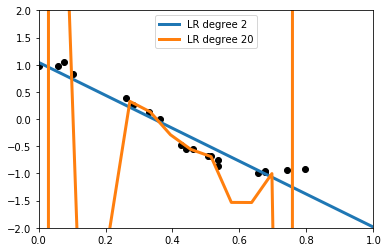

In [4]:
# prepare models
models = []
predicts = []
names=[]
models.append(('LR degree 2', make_pipeline(PolynomialFeatures(1), linear_model.LinearRegression()) ))
models.append(('LR degree 20', make_pipeline(PolynomialFeatures(20), linear_model.LinearRegression()) ))

x_plot = np.vstack(np.linspace(-3, 3, 100))
for name, model in models:
    print(name)
    model.fit(x, y)
    predicts.append(model.predict(x_plot))
    names.append(name)
    
x_plot = np.vstack(np.linspace(-3, 3, 100))
plt.plot(x, y, 'ok');
for i in range(len(models)):
    #print(i)
    plt.plot(x_plot, predicts[i],linewidth=3,label=names[i])
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
plt.legend()    
plt.show()    

# Ridge regression $l_2$

Ridge regression próbuje rozwiązać niektóre problemy klasycznej regresji liniowej, nakładając kary za wykorzystanie większej ilości współrzędnych. Ridge regression minimalizuje:
$$
\underset{w}{min\,} {{|| X w - y||_2}^2 + \alpha {||w||_2}^2},
$$
gdzie:
$$
 \left\|{w}\right\|_{2}={\sqrt {w_{1}^{2}+\cdots +w_{n}^{2}}}.
$$

Parametr $\alpha \geq 0$ jest parametrem złożoności, który kontroluje wielkość kary; im większa jest wartość $\alpha$, tym większa kara.

# Lasso regression $l_1$

Lasso regression próbuje rozwiązać niektóre problemy klasycznej regresji liniowej, nakładając kary za wykorzystanie większej ilości współrzędnych. Lasso regression minimalizuje:
$$
\underset{w}{min\,} {{|| X w - y||_2}^2 + \alpha {||w||_1}^2},
$$
gdzie:
$$
\left\|{w}\right\|_{1}=\sum _{i=1}^{n}\left|w_{i}\right|.
$$

# Zadanie 
Proszę wykonać 
* regresję dla wielomianów o stopniu **20**
* regresję (Ridge Regression) dla wielomianów o stopniu **20**
* regresję (Lasso Regression) dla wielomianów o stopniu **20**



LR degree 20
Ridge degree 20
Lasso degree 20


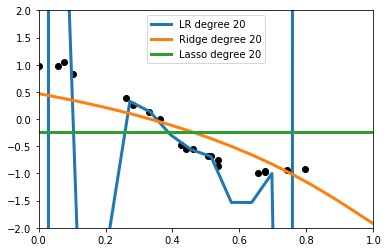

In [5]:
# prepare models
models = []
predicts = []
names=[]
models.append(('LR degree 20', make_pipeline(PolynomialFeatures(20), linear_model.LinearRegression()) ))
models.append(('Ridge degree 20', make_pipeline(PolynomialFeatures(20), linear_model.Ridge()) ))
models.append(('Lasso degree 20', make_pipeline(PolynomialFeatures(20), linear_model.Lasso()) ))

x_plot = np.vstack(np.linspace(-3, 3, 100))
for name, model in models:
    print(name)
    model.fit(x, y)
    predicts.append(model.predict(x_plot))
    names.append(name)
    
x_plot = np.vstack(np.linspace(-3, 3, 100))
plt.plot(x, y, 'ok');
for i in range(len(models)):
    #print(i)
    plt.plot(x_plot, predicts[i],linewidth=3,label=names[i])
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
plt.legend()    
plt.show()    